# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime 

In [33]:
pd.set_option('display.max_columns', 500)

# Load data

In [167]:
data = pd.read_csv("../data/clickdata.csv")

data.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,NaN,ANONYMOUS,Robot
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,NaN,ANONYMOUS,Robot
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,NaN,ANONYMOUS,Robot
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,NaN,ANONYMOUS,Robot Mobile


## Preprocessing

In [168]:
# Filling in missing values
data.loc[data['country_by_ip_address'].isna(), 'country_by_ip_address'] = 'UNK'
data.loc[data['region_by_ip_address'].isna(), 'region_by_ip_address'] = 'UNK'
data.loc[data['referrer_without_parameters'].isna(), 'referrer_without_parameters'] = ''

# Splitting class into class and source
data.loc[data['ua_agent_class'] == 'Browser Webview', 'ua_source'] = 'Webview'
data.loc[data['ua_agent_class'] == 'Browser Webview', 'ua_agent_class'] = 'Browser'
data.loc[data['ua_agent_class'] == 'Robot Mobile', 'ua_source'] = 'Mobile'
data.loc[data['ua_agent_class'] == 'Robot Mobile', 'ua_agent_class'] = 'Robot'

# Getting a url sub class. This is a placeholder for the detailed url breakdown
data['url_subclass'] = data['url_without_parameters'].apply(lambda url: url.removeprefix('https://www.bol.com/nl/').split('/')[0])

# Stub for time stamp processing
# datetime.fromtimestamp(1520280004428/1000.0).strftime('%m-%d %H:%M:%S')

data.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class,ua_source,url_subclass
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,,ANONYMOUS,Robot,NaN,l
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,,ANONYMOUS,Robot,NaN,l
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser,NaN,p
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,,ANONYMOUS,Robot,NaN,l
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,,ANONYMOUS,Robot,Mobile,l


## URL parsing
It's own section cos it's a lil complicated

In [ ]:
def parse_url(url, prefix = 'https://www.bol.com/nl/'):
    def is_product_code(x):
        pass

    url_components = url.removeprefix(prefix).split('/')
    row = {
        'url_function': '',
        'category': '',
        'category_id': '',
        'category_filters': [],
        'n_category_filters': 0,
        'attribute_filters': [],
        'n_attribute_filters': 0,
        'search_type': '',
        'search_text': '',
        'search_context': '',
        'Nty': '',
        'product_id': '',
        'other': '',
        'tracking_id': ''
    }

    if url_components[0] == 'c':
        row['url_function'] = url_components[0]

        if url_components[1] == 'ajax':
            row['other'] = url_components[1]

        else:
            row['category'] = url_components[1]

            if url_components[2].isdigit():
                row['category_id'] = url_components[2]

            else:
                row['category'] = row['category'] + '/' + url_components[2]

                if url_components[3].isdigit():
                    row['category_id'] = url_components[3]

        if 'N' in url_components:
            index = url_components.index('N')
            row['category_filters'] = url_components[index + 1].split('+')

        if 'sc' in url_components:
            index = url_components.index('sc')
            row['search_context'] = url_components[index + 1]

        if 'filter_N' in url_components:
            index = url_components.index('filter_N')
            row['attribute_filters'] = url_components[index + 1].split('+')

    elif url_components[0] == 'checkout':
        row['url_function'] = url_components[0]
        row['other'] = url_components[1]

    elif url_components[0] == 'l':
        row['url_function'] = url_components[0]

        if url_components[1] == 'ajax':
            row['other'] = url_components[1]

        else:
            row['category'] = url_components[1]

        if 'N' in url_components:
            index = url_components.index('N')
            row['category_filters'] = url_components[index + 1].split('+')

        if 'filter_N' in url_components:
            index = url_components.index('filter_N')
            row['attribute_filters'] = url_components[index + 1].split('+')

    elif url_components[0] == 'order':
        row['url_function'] = url_components[0]
        row['other'] = url_components[1]

    elif url_components[0] == 'p':
        row['url_function'] = url_components[0]
        row['category'] = url_components[1]

        if url_components[2].isdigit():
            row['product_id'] = url_components[2]

    elif url_components[0] == 's':
        row['url_function'] = url_components[0]

        if url_components[1].isdigit():
            row['category_id'] = url_components[1]
        
        else:
            row['category'] = url_components[1]

        if 'N' in url_components:
            index = url_components.index('N')
            row['category_filters'] = url_components[index + 1].split('+')

        if 'Ntt' in url_components:
            index = url_components.index('Ntt')
            row['search_text'] = url_components[index + 1]

        if 'Nty' in url_components:
            index = url_components.index('Nty')
            row['Nty'] = url_components[index + 1]

        if 'sc' in url_components:
            index = url_components.index('sc')
            row['search_context'] = url_components[index + 1]

        if 'filter_N' in url_components:
            index = url_components.index('filter_N')
            row['attribute_filters'] = url_components[index + 1].split('+')

        if 'ajax' in url_components:
            row['other'] = 'ajax'

    elif url_components[0] == 'w':
        row['url_function'] = url_components[0]

        if url_components[1] == 'ajax':
            row['other'] = url_components[1]

        else:
            row['category'] = url_components[1]

            if url_components[2].isdigit():
                row['tracking_id'] = url_components[2]

            else:
                row['category'] = row['category'] + '/' + url_components[2]
                row['tracking_id'] = url_components[3]

            if 'N' in url_components:
                index = url_components.index('N')
                row['category_filters'] = url_components[index + 1].split('+')

            if 'filter_N' in url_components:
                index = url_components.index('filter_N')
                row['attribute_filters'] = url_components[index + 1].split('+')              

    row['n_category_filters'] = len(row['category_filters'])
    row['n_attribute_filters'] = len(row['attribute_filters'])

    return pd.Series(row)

# ['t', 'account', 'ra', 'm', 'b', 'lijstjes', 'service', 'serie', 'f', 'u', 'persoonlijke-aanbevelingen', 'elektronica', 'review-schrijven', 'computer', 'i', 'dvd', 'muziek', 'boeken', 'artikel-niet-meer-leverbaar', 'subcheckout', 'verlanglijstje', 'speelgoed'])


In [170]:
url_features = ['url_function',
                'category',
                'category_id',
                'category_filters',
                'n_category_filters',
                'attribute_filters',
                'n_attribute_filters',
                'search_type',
                'search_text',
                'search_context',
                'Nty',
                'product_id',
                'other',
                'tracking_id']

data[url_features] = data['url_without_parameters'].apply(lambda url: parse_url(url))

In [171]:
data.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class,ua_source,url_subclass,url_function,category,category_id,category_filters,n_category_filters,attribute_filters,n_attribute_filters,search_type,search_text,search_context,Nty,product_id,other,tracking_id
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,,ANONYMOUS,Robot,NaN,l,l,nederlandstalige-kunstgeschiedenis-theorie-ove...,,"[2324, 24596, 8293]",3,[],0,,,,,,,
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,,ANONYMOUS,Robot,NaN,l,l,italiaans-natuur-wetenschap-kinderboeken-over-...,,"[24435, 26558, 24670, 7419]",4,[],0,,,,,,,
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser,NaN,p,p,nespresso-magimix-inissia-m105-koffiemachine-grey,,[],0,[],0,,,,,9200000025533140,,
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,,ANONYMOUS,Robot,NaN,l,l,nieuwe-engelstalige-outdoor-sportboeken-algeme...,,"[2806, 4292595594, 4288403245, 4288398652, 140...",6,[4273962351],1,,,,,,,
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,,ANONYMOUS,Robot,Mobile,l,l,nieuwe-actie-avontuur-over-prive-detective,,"[33590, 26931, 7289]",3,[],0,,,,,,,


## N rows

In [57]:
len(data.index)

59782

## Grouped by ua_agent_class

In [101]:
data.groupby(['ua_agent_class']).count()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_source,url_subclass
ua_agent_class,,,,,,,,,
Browser,37309,37309,37309,37309,37309,37309,37309,1800,37309
Cloud Application,2,2,2,2,2,2,2,0,2
Hacker,1177,1177,1177,1177,1177,1177,1177,0,1177
Mobile App,9,9,9,9,9,9,9,0,9
Robot,21141,21141,21141,21141,21141,21141,21141,5115,21141
Special,144,144,144,144,144,144,144,0,144


In [59]:
data.pivot_table(index='ua_agent_class', columns='visitor_recognition_type', values='epoch_ms', aggfunc='count')

visitor_recognition_type,ANONYMOUS,LOGGEDIN,RECOGNIZED
ua_agent_class,,,
Browser,21239.0,3482.0,12588.0
Cloud Application,2.0,NaN,NaN
Hacker,1176.0,NaN,1.0
Mobile App,9.0,NaN,NaN
Robot,21141.0,NaN,NaN
Special,144.0,NaN,NaN


## Grouped by url subclass

In [102]:
data.pivot_table(index='url_subclass', columns='ua_agent_class', values='epoch_ms', aggfunc='count')

ua_agent_class,Browser,Cloud Application,Hacker,Mobile App,Robot,Special
url_subclass,,,,,,
account,1177.0,NaN,NaN,NaN,NaN,1.0
artikel-niet-meer-leverbaar,2.0,NaN,NaN,NaN,3.0,NaN
b,301.0,NaN,14.0,NaN,131.0,2.0
boeken,4.0,NaN,NaN,NaN,NaN,NaN
c,170.0,NaN,16.0,NaN,2094.0,NaN
checkout,1377.0,NaN,12.0,NaN,NaN,NaN
computer,1.0,NaN,NaN,NaN,NaN,NaN
dvd,2.0,NaN,NaN,NaN,NaN,NaN
elektronica,2.0,NaN,NaN,NaN,1.0,NaN


## Distribution of events by session id 

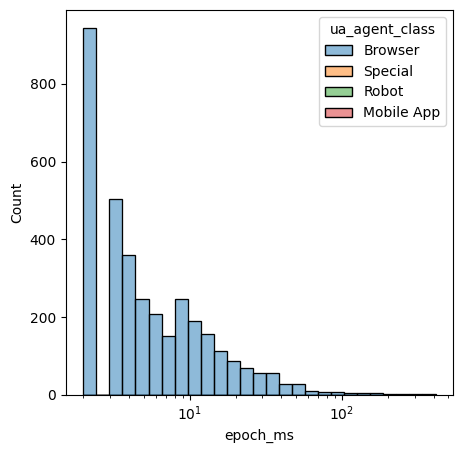

In [67]:
events_per_session_id = data.groupby(['session_id', 'ua_agent_class'])['epoch_ms'].count().reset_index()

plt.figure(figsize=(5, 5))

sns.histplot(events_per_session_id[events_per_session_id['epoch_ms'] > 1], x='epoch_ms', hue='ua_agent_class', log_scale=True)

plt.show()

In [153]:
print(events_per_session_id.loc[events_per_session_id['ua_agent_class'] == 'Robot'].sort_values(by='epoch_ms', ascending=False).head().to_string())

                            session_id ua_agent_class  epoch_ms
4747  27fc1af6b8e02fe030868ede36ceb725          Robot        12
7     0015be2897da1fc074276da2f912e245          Robot         1
9     0016a4fabea3eb066a369565d4c07143          Robot         1
10    001751c4ae4097d4dd86a1b23b40380d          Robot         1
13    001aee4c31308bb92dc91f01a673fbef          Robot         1


## Referrer url is different.

In [ ]:
data.loc[~data['referrer_without_parameters'].isna() & (data['url_without_parameters'] != data['referrer_without_parameters'])]

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
6,1520280011959,1483702c6372dfc7a4eef3ab35380f50,NL,UT,https://www.bol.com/nl/p/beddinghouse-multifit...,https://www.bol.com/nl/l/beddinghouse-matrasbe...,ANONYMOUS,Browser
11,1520280014898,1639871bba582eaec426e24427ad407d,NL,NB,https://www.bol.com/nl/l/kinderboeken-ebook/N/...,https://www.bol.com/nl/m/nederlandse-boeken/ko...,ANONYMOUS,Browser
23,1520280028389,2816abd88decbc2759738a8e4b3e0f98,NL,DR,https://www.bol.com/nl/p/cadac-universele-druk...,https://www.bol.com/nl/p/bbq-collection-gasbar...,ANONYMOUS,Browser
26,1520280033070,160fdd31c0a5ecfb6e27d0c9e99eceaa,NL,UT,https://www.bol.com/nl/p/ducksday-zomer-poncho...,https://www.bol.com/nl/s/algemeen/zoekresultat...,RECOGNIZED,Browser
32,1520280035130,e8b6f52bc82659fb96dcd6115787dba7,NL,NB,https://www.bol.com/nl/account/login.html,https://www.bol.com/nl/m/service/lekker-winkel...,ANONYMOUS,Browser


## What are they searching for?

| Prefix    | Meaning                                  | Example URL                                                | What it shows                    |
| --------- | ---------------------------------------- | ---------------------------------------------------------- | -------------------------------- |
| `/s/`     | **Search**                               | `/s/?searchtext=airpods`                                   | Search result pages              |
| `/l/`     | **List**                                 | `/l/laptops/4770/`                                         | Filtered or themed product lists |
| `/p/`     | **Product**                              | `/p/apple-airpods-pro/9200000073524040/`                   | Single product detail page       |
| `/b/`     | **Brand**                                | `/b/apple/` or `/b/kinderkleding-jongens-tumble-n-dry/...` | Brand landing pages              |
| `/c/`     | **Category**                             | `/c/muziek/31360/`                                         | Category overview pages          |
| `/f/`     | **Feature page** or **thematic landing** | `/f/aanbiedingen/` or `/f/feestdagen/`                     | Campaigns, promos, sales         |
| `/m/`     | **Marketing or deals page**              | `/m/koopjes/`                                              | Curated deal collections         |
| `/r/`     | **Reviews**                              | `/r/product-reviews/...`                                   | User reviews of products         |
| `/order/` | **Checkout flow**                        | `/order/basket.html`                                       | Cart and checkout pages          |
| `/rnwy/`  | **User account** (Runway?)               | `/rnwy/account/`                                           | Login, orders, personal info     |


| Prefix | Likely Purpose                         | Visibility to Users |
| ------ | -------------------------------------- | ------------------- |
| `/t/`  | Tracking / script redirects            | ❌ Rare              |
| `/u/`  | Unique or campaign-specific routing    | ❌ Rare              |
| `/w/`  | Web hooks or internal workflow support | ❌ Rare              |


In [5]:
parsed_urls = {}

for url in data['url_without_parameters'].to_list():
    url_split = url.removeprefix('https://www.bol.com/nl/').split('/')

    pointer = parsed_urls
    for item in url_split:
        if item not in pointer:
            pointer[item] = {}

        pointer = pointer[item]

import pprint
# pprint.pprint(parsed_urls)

In [6]:
parsed_urls.keys()

dict_keys(['l', 'p', 'order', 't', 'c', 'checkout', 's', 'w', 'account', 'ra', 'm', 'b', 'lijstjes', 'service', 'serie', 'f', 'u', 'persoonlijke-aanbevelingen', 'elektronica', 'review-schrijven', 'computer', 'i', 'dvd', 'muziek', 'boeken', 'artikel-niet-meer-leverbaar', 'subcheckout', 'verlanglijstje', 'speelgoed'])

In [52]:
data.loc[data['url_without_parameters'].str.contains('Nty/')]['url_without_parameters'].to_list()[:10]

['https://www.bol.com/nl/s/muziek/zoekresultaten/Ntt/Star%2520Wars/3132/Nty/1/search/true/searchType/qck/defaultSearchContext/media_all/sc/music_all/index.html',
 'https://www.bol.com/nl/s/muziek/zoekresultaten/Ntt/Zed%2520Bias/3132/Nty/1/search/true/searchType/qck/defaultSearchContext/media_all/sc/music_all/index.html',
 'https://www.bol.com/nl/s/muziek/zoekresultaten/Ntt/The%2520Bulgarian%2520Voices%2520Angelite/3132/Nty/1/search/true/searchType/qck/defaultSearchContext/media_all/sc/music_all/index.html',
 'https://www.bol.com/nl/s/muziek/zoekresultaten/Ntt/Lazy%2520Boys/3132/Nty/1/search/true/searchType/qck/defaultSearchContext/media_all/sc/music_all/index.html',
 'https://www.bol.com/nl/s/algemeen/zoekresultaten/Ntt/Recoil/N/0/Nty/1/search/true/searchType/qck/defaultSearchContext/media_all/sc/media_all/index.html',
 'https://www.bol.com/nl/s/muziek/zoekresultaten/Ntt/Freni/3132/Nty/1/search/true/searchType/qck/defaultSearchContext/media_all/sc/music_all/index.html',
 'https://www.b

In [148]:
data.loc[data['url_without_parameters'].str.contains('/c/')]['url_without_parameters'].to_list()[:10]

['https://www.bol.com/nl/c/algemeen/arthur-koch/116630/index.html',
 'https://www.bol.com/nl/c/m-j-evans/7790937/',
 'https://www.bol.com/nl/c/peta-fowler/590790/',
 'https://www.bol.com/nl/c/vesna-lazic/9483505/',
 'https://www.bol.com/nl/c/ajax/index.html',
 'https://www.bol.com/nl/c/laurent-lechowski/16370210/',
 'https://www.bol.com/nl/c/bouniol-b/16948827/',
 'https://www.bol.com/nl/c/algemeen/r-w-k-clark/13852319/index.html',
 'https://www.bol.com/nl/c/eric-hou/4257278/',
 'https://www.bol.com/nl/c/brianna-wolfson/15099551/']

In [172]:
pprint.pprint(parsed_urls['s'])

{'4958522222386': {},
 'ajax': {'index.html': {}},
 'algemeen': {'zoekresultaten': {'N': {'8293': {'sc': {'media_all': {'searchRedirectType': {'apu': {'index.html': {}}}}}}},
                                 'Ntt': {'': {'N': {'0': {'Nty': {'1': {'search': {'true': {'searchType': {'qck': {'defaultSearchContext': {'media_all': {'sc': {'media_all': {'index.htmlprijsoverzicht': {'': {}}}}}}}}}}}}}}},
                                         '0889899027097': {'N': {'0': {'Nty': {'1': {'search': {'true': {'searchType': {'qck': {'defaultSearchContext': {'media_all': {'sc': {'media_all': {'index.htmlprijsoverzicht': {'': {}}}}}}}}}}}}}}},
                                         '091209838648': {'N': {'0': {'Nty': {'1': {'search': {'true': {'searchType': {'qck': {'sc': {'media_all': {'index.html': {}}}}}}}}}}}},
                                         '885178495878': {'N': {'0': {'Nty': {'1': {'search': {'true': {'searchType': {'qck': {'sc': {'media_all': {'index.html': {}}}}}}}}}}}},
      